In this example, we will create a typical CANDU bundle with rings of fuel pins. At present, OpenMC does not have a specialized lattice for this type of fuel arrangement, so we must resort to manual creation of the array of fuel pins.

In [1]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc

Let's begin by creating the materials that will be used in our model.

In [2]:
fuel = openmc.Material(name='fuel')
fuel.add_element('U', 1.0)
fuel.add_element('O', 2.0)
fuel.set_density('g/cm3', 10.0)

clad = openmc.Material(name='zircaloy')
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 6.0)

heavy_water = openmc.Material(name='heavy water')
heavy_water.add_nuclide('H2', 2.0)
heavy_water.add_nuclide('O16', 1.0)
heavy_water.add_s_alpha_beta('c_D_in_D2O')
heavy_water.set_density('g/cm3', 1.1)

With our materials created, we'll now define key dimensions in our model. These dimensions are taken from the example in section 11.1.3 of the [Serpent manual](http://montecarlo.vtt.fi/download/Serpent_manual.pdf).

In [3]:
# Outer radius of fuel and clad
r_fuel = 0.6122
r_clad = 0.6540

# Pressure tube and calendria radii
pressure_tube_ir = 5.16890
pressure_tube_or = 5.60320
calendria_ir = 6.44780
calendria_or = 6.58750

# Radius to center of each ring of fuel pins
ring_radii = np.array([0.0, 1.4885, 2.8755, 4.3305])

To begin creating the bundle, we'll first create annular regions completely filled with heavy water and add in the fuel pins later. The radii that we've specified above correspond to the center of each ring. We actually need to create cylindrical surfaces at radii that are half-way between the centers.

In [4]:
# These are the surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

water_cells = []
for i in range(ring_radii.size):
    # Create annular region
    if i == 0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i-1]
    else:
        water_region = +radial_surf[i-1] & -radial_surf[i]
        
    water_cells.append(openmc.Cell(fill=heavy_water, region=water_region))

Let's see what our geometry looks like so far. In order to plot the geometry, we create a universe that contains the annular water cells and then use the `Universe.plot()` method. While we're at it, we'll set some keyword arguments that can be reused for later plots.

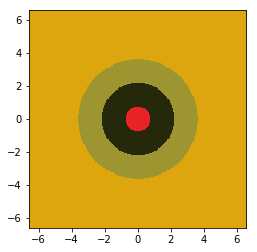

In [5]:
plot_args = {'width': (2*calendria_or, 2*calendria_or)}
bundle_universe = openmc.Universe(cells=water_cells)
bundle_universe.plot(**plot_args)

Now we need to create a universe that contains a fuel pin. Note that we don't actually need to put water outside of the cladding in this universe because it will be truncated by a higher universe.

In [6]:
surf_fuel = openmc.ZCylinder(r=r_fuel)

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
clad_cell = openmc.Cell(fill=clad, region=+surf_fuel)

pin_universe = openmc.Universe(cells=(fuel_cell, clad_cell))

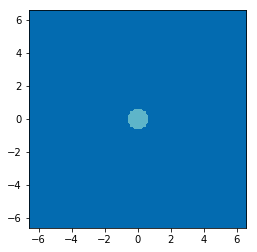

In [7]:
pin_universe.plot(**plot_args)

The code below works through each ring to create a cell containing the fuel pin universe. As each fuel pin is created, we modify the region of the water cell to include everything outside the fuel pin.

In [8]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        # Determine location of center of pin
        theta = (a + j/n*360.) * pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_clad)
        water_cells[i].region &= +pin_boundary
        
        # Create each fuel pin -- note that we explicitly assign an ID so 
        # that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

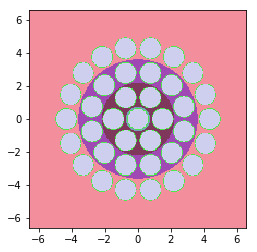

In [9]:
bundle_universe.plot(**plot_args)

Looking pretty good! Finally, we create cells for the pressure tube and calendria and then put our bundle in the middle of the pressure tube.

In [10]:
pt_inner = openmc.ZCylinder(r=pressure_tube_ir)
pt_outer = openmc.ZCylinder(r=pressure_tube_or)
calendria_inner = openmc.ZCylinder(r=calendria_ir)
calendria_outer = openmc.ZCylinder(r=calendria_or, boundary_type='vacuum')

bundle = openmc.Cell(fill=bundle_universe, region=-pt_inner)
pressure_tube = openmc.Cell(fill=clad, region=+pt_inner & -pt_outer)
v1 = openmc.Cell(region=+pt_outer & -calendria_inner)
calendria = openmc.Cell(fill=clad, region=+calendria_inner & -calendria_outer)

root_universe = openmc.Universe(cells=[bundle, pressure_tube, v1, calendria])

Let's look at the final product. We'll export our geometry and materials and then use `plot_inline()` to get a nice-looking plot.

In [11]:
geom = openmc.Geometry(root_universe)
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values())
mats.export_to_xml()

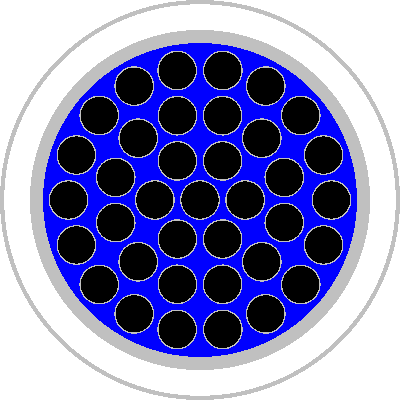

In [12]:
p = openmc.Plot.from_geometry(geom)
p.color_by = 'material'
p.colors = {
    fuel: 'black',
    clad: 'silver',
    heavy_water: 'blue'
}
p.to_ipython_image()

## Interpreting Results

One of the difficulties of a geometry like this is identifying tally results when there was no lattice involved. To address this, we specifically gave an ID to each fuel pin of the form 100\*ring + azimuthal position. Consequently, we can use a distribcell tally and then look at our `DataFrame` which will show these cell IDs.

In [13]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 20
settings.inactive = 10
settings.source = openmc.Source(space=openmc.stats.Point())
settings.export_to_xml()

In [14]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell)]
fuel_tally.scores = ['flux']

tallies = openmc.Tallies([fuel_tally])
tallies.export_to_xml()

In [15]:
openmc.run(output=False)

The return code of `0` indicates that OpenMC ran successfully. Now let's load the statepoint into a `openmc.StatePoint` object and use the `Tally.get_pandas_dataframe(...)` method to see our results.

In [16]:
sp = openmc.StatePoint('statepoint.{}.h5'.format(settings.batches))

In [17]:
t = sp.get_tally()
t.get_pandas_dataframe()

level 1      level 2      level 3      distribcell nuclide score     mean  \
      univ cell    univ cell    univ cell                                      
        id   id      id   id      id   id                                      
0        3   44       1  100       2    5           0   total  flux 2.08e-01   
1        3   44       1  200       2    5           1   total  flux 1.97e-01   
2        3   44       1  201       2    5           2   total  flux 1.90e-01   
3        3   44       1  202       2    5           3   total  flux 1.95e-01   
4        3   44       1  203       2    5           4   total  flux 1.91e-01   
5        3   44       1  204       2    5           5   total  flux 1.90e-01   
6        3   44       1  205       2    5           6   total  flux 1.82e-01   
7        3   44       1  300       2    5           7   total  flux 1.66e-01   
8        3   44       1  301       2    5           8   total  flux 1.69e-01   
9        3   44       1  302       2    5           9   total  flux 1.60e-01   
10       3   44       1  303       2    5          10   total  flux 1.59e-01   
11       3   44       1  304       2    5          11   total  flux 1.49e-01   
12       3   44       1  305       2    5          12   total  flux 1.51e-01   
13       3   44       1  306       2    5          13   total  flux 1.54e-01   
14       3   44       1  307       2    5          14   total  flux 1.66e-01   
15       3   44       1  308       2    5          15   total  flux 1.57e-01   
16       3   44       1  309       2    5          16   total  flux 1.65e-01   
17       3   44       1  310       2    5          17   total  flux 1.57e-01   
18       3   44       1  311       2    5          18   total  flux 1.60e-01   
19       3   44       1  400       2    5          19   total  flux 9.66e-02   
20       3   44       1  401       2    5          20   total  flux 1.18e-01   
21       3   44       1  402       2    5          21   total  flux 1.06e-01   
22       3   44       1  403       2    5          22   total  flux 1.11e-01   
23       3   44       1  404       2    5          23   total  flux 1.12e-01   
24       3   44       1  405       2    5          24   total  flux 1.10e-01   
25       3   44       1  406       2    5          25   total  flux 1.00e-01   
26       3   44       1  407       2    5          26   total  flux 9.54e-02   
27       3   44       1  408       2    5          27   total  flux 9.26e-02   
28       3   44       1  409       2    5          28   total  flux 9.55e-02   
29       3   44       1  410       2    5          29   total  flux 1.14e-01   
30       3   44       1  411       2    5          30   total  flux 1.08e-01   
31       3   44       1  412       2    5          31   total  flux 1.07e-01   
32       3   44       1  413       2    5          32   total  flux 1.12e-01   
33       3   44       1  414       2    5          33   total  flux 1.15e-01   
34       3   44       1  415       2    5          34   total  flux 1.14e-01   
35       3   44       1  416       2    5          35   total  flux 1.14e-01   
36       3   44       1  417       2    5          36   total  flux 1.11e-01   

   std. dev.  
              
              
0   7.04e-03  
1   5.27e-03  
2   7.82e-03  
3   6.47e-03  
4   6.43e-03  
5   4.89e-03  
6   3.85e-03  
7   5.82e-03  
8   8.30e-03  
9   3.09e-03  
10  5.91e-03  
11  5.31e-03  
12  6.65e-03  
13  3.67e-03  
14  4.73e-03  
15  6.54e-03  
16  5.94e-03  
17  5.73e-03  
18  4.58e-03  
19  4.47e-03  
20  5.45e-03  
21  4.72e-03  
22  4.21e-03  
23  5.08e-03  
24  4.15e-03  
25  5.08e-03  
26  3.62e-03  
27  4.00e-03  
28  4.02e-03  
29  9.53e-03  
30  7.24e-03  
31  5.72e-03  
32  5.00e-03  
33  6.24e-03  
34  4.92e-03  
35  5.32e-03  
36  5.05e-03

We can see that in the 'level 2' column, the 'cell id' tells us how each row corresponds to a ring and azimuthal position.